In [20]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

## Import Libraries

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [23]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [24]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


In [25]:
def display_image_and_mask( img, mask, img_shape, mask_shape ):  
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    # Display image
    axs[0].imshow(img)
    axs[0].set_title(f'Image with shape: {img_shape}')
    axs[0].axis('off')  # Hide axes for better visualization

    # Display mask
    axs[1].imshow(mask)
    axs[1].set_title(f'Mask with shape: {mask_shape}')
    axs[1].axis('off')  # Hide axes for better visualization

    # Show the plot
    plt.tight_layout()
    plt.show()

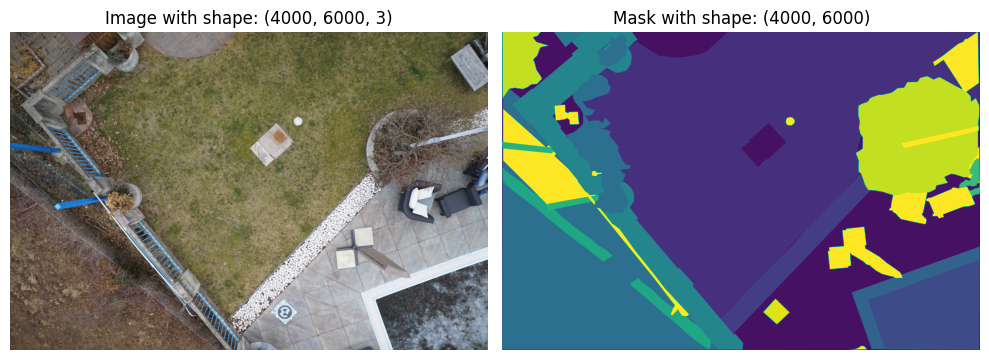

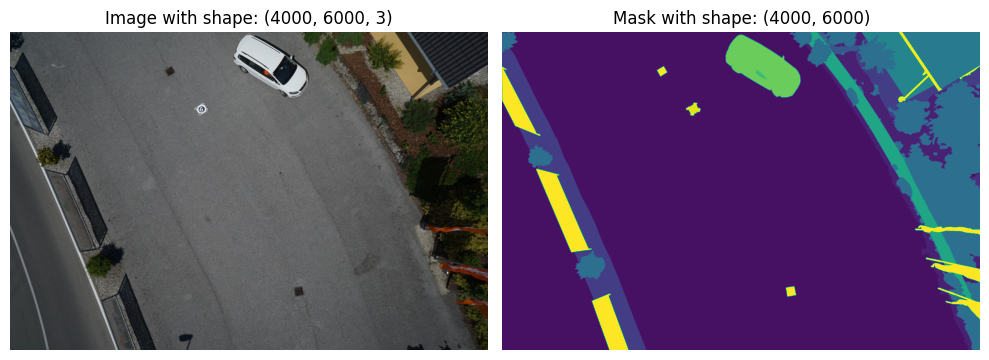

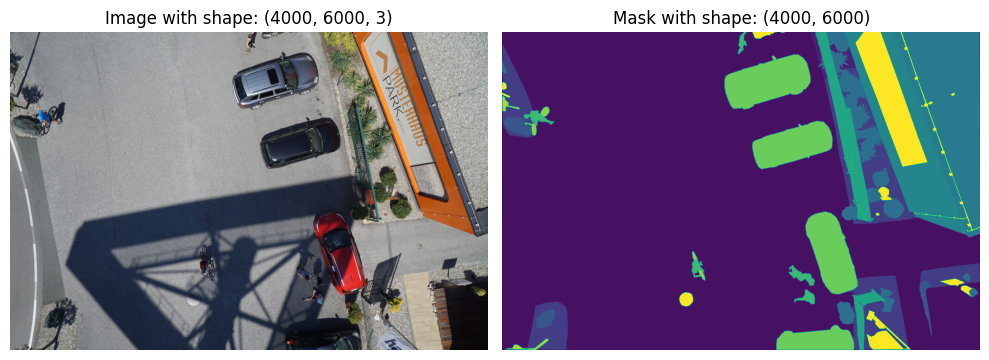

In [26]:
for i in [0,100, 200]:    
    img  = Image.open( IMAGE_PATH + df['id'][i] + '.jpg' )
    mask = Image.open( MASK_PATH  + df['id'][i] + '.png'  )
    display_image_and_mask( img, mask, np.asarray(img).shape, np.asarray(mask).shape  )


## DATASET

In [27]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path  = img_path
        self.mask_path = mask_path
        self.X         = X
        self.transform = transform
        self.patches   = patch
        self.mean      = mean
        self.std       = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img  = cv2.imread( self.img_path + self.X[idx] + '.jpg' )
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread( self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE )
        
#         print(f'shape of image {img.shape}')
#         print(f'shape of mask  {mask.shape}')
        
        if self.transform is not None:
#             print('Inside the transfrom true case')
            aug  = self.transform( image = img, mask = mask )
            # converts a NumPy array (aug['image']) back into a PIL
            img  = Image.fromarray( aug['image'] )  
            mask = aug['mask']
        
#         print(f'Shape of the mask after transform: {mask.shape}')
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t    = T.Compose( [ T.ToTensor(), 
                            T.Normalize( self.mean, self.std ) ] )
        img  = t(img)
        mask = torch.from_numpy(mask).long()
               
        if self.patches:
            print('Inside the patches if condition')
            img, mask = self.tiles(img, mask)
    
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    

In [28]:
mean = [ 0.485, 0.456, 0.406 ]
std  = [ 0.229, 0.224, 0.225 ]

t_display = A.Compose( [ A.Resize( 704, 1056, interpolation = cv2.INTER_NEAREST ), 
                         A.HorizontalFlip(), 
                         A.VerticalFlip(), 
                         A.GridDistortion( p = 0.2 ), 
                         A.RandomBrightnessContrast( (0,0.5),(0,0.5) ),
                         A.GaussNoise(), 
                         A.Normalize( mean, std ),
                         ToTensorV2() ])

t_train = A.Compose( [ A.Resize( 704, 1056, interpolation = cv2.INTER_NEAREST ), 
                       A.HorizontalFlip(), 
                       A.VerticalFlip(), 
                       A.GridDistortion( p = 0.2 ), 
                       A.RandomBrightnessContrast( (0,0.5),(0,0.5) ),
                       A.GaussNoise() ])

t_val   = A.Compose( [ A.Resize( 704, 1056, interpolation = cv2.INTER_NEAREST ), 
                       A.HorizontalFlip(),
                       A.GridDistortion( p = 0.2 ) ])              

In [29]:
### testing DroneDataset class
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch = False )
img, mask = train_set.__getitem__(0)
print(f'shape of image: {img.shape},  type: {type(img)}')
print(f'shape of mask : {mask.shape},     type: {type(mask)}')
np.unique(mask)

shape of image: torch.Size([3, 704, 1056]),  type: <class 'torch.Tensor'>
shape of mask : torch.Size([704, 1056]),     type: <class 'torch.Tensor'>


array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 15, 17, 18, 19, 21, 22])

### Plot Augmented images

In [30]:
# Function to display original and augmented images
def display_augmented_samples( img_path, gt_path, transform_list ):


    img = Image.open(img_path).convert('RGB')
    gt  = Image.open(gt_path)

    original_image = np.array(img)
    original_gt    = np.array(gt).astype(np.float32)
#     original_gt    = original_gt / 255.0  # Normalize ground truth to be between 0 and 1

    # Number of images to display
    num_images = 16
    images_per_row = 4
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Ceiling division

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(16, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Display the original image and mask
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[1].imshow(original_gt)
    axes[1].set_title('Original Mask')

    count = 2  # Start from 2 because the first two slots are occupied by the original image and mask

    for i in range( len(transform_list)-1 ):
        if count >= num_images:
            break  # Stop if we've filled all the required slots

        augmented = A.Compose([transform_list[i], ToTensorV2()])(image=original_image, mask=original_gt)
        augmented_image = augmented['image'].permute(1, 2, 0).numpy()
        augmented_gt    = augmented['mask'].squeeze(0).numpy()

        axes[count].imshow(augmented_image)
        axes[count].set_title(f'Augmented Image {i + 1}: {transform_list[i].__class__.__name__}')
        count += 1
    
        if count >= num_images:
            break  # Stop if we've filled all the required slots

        axes[count].imshow(augmented_gt)
        axes[count].set_title(f'Augmented Mask {i + 1}: {transform_list[i].__class__.__name__}')
        count += 1

    # Turn off any remaining empty axes
    for j in range(count, num_rows * images_per_row):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

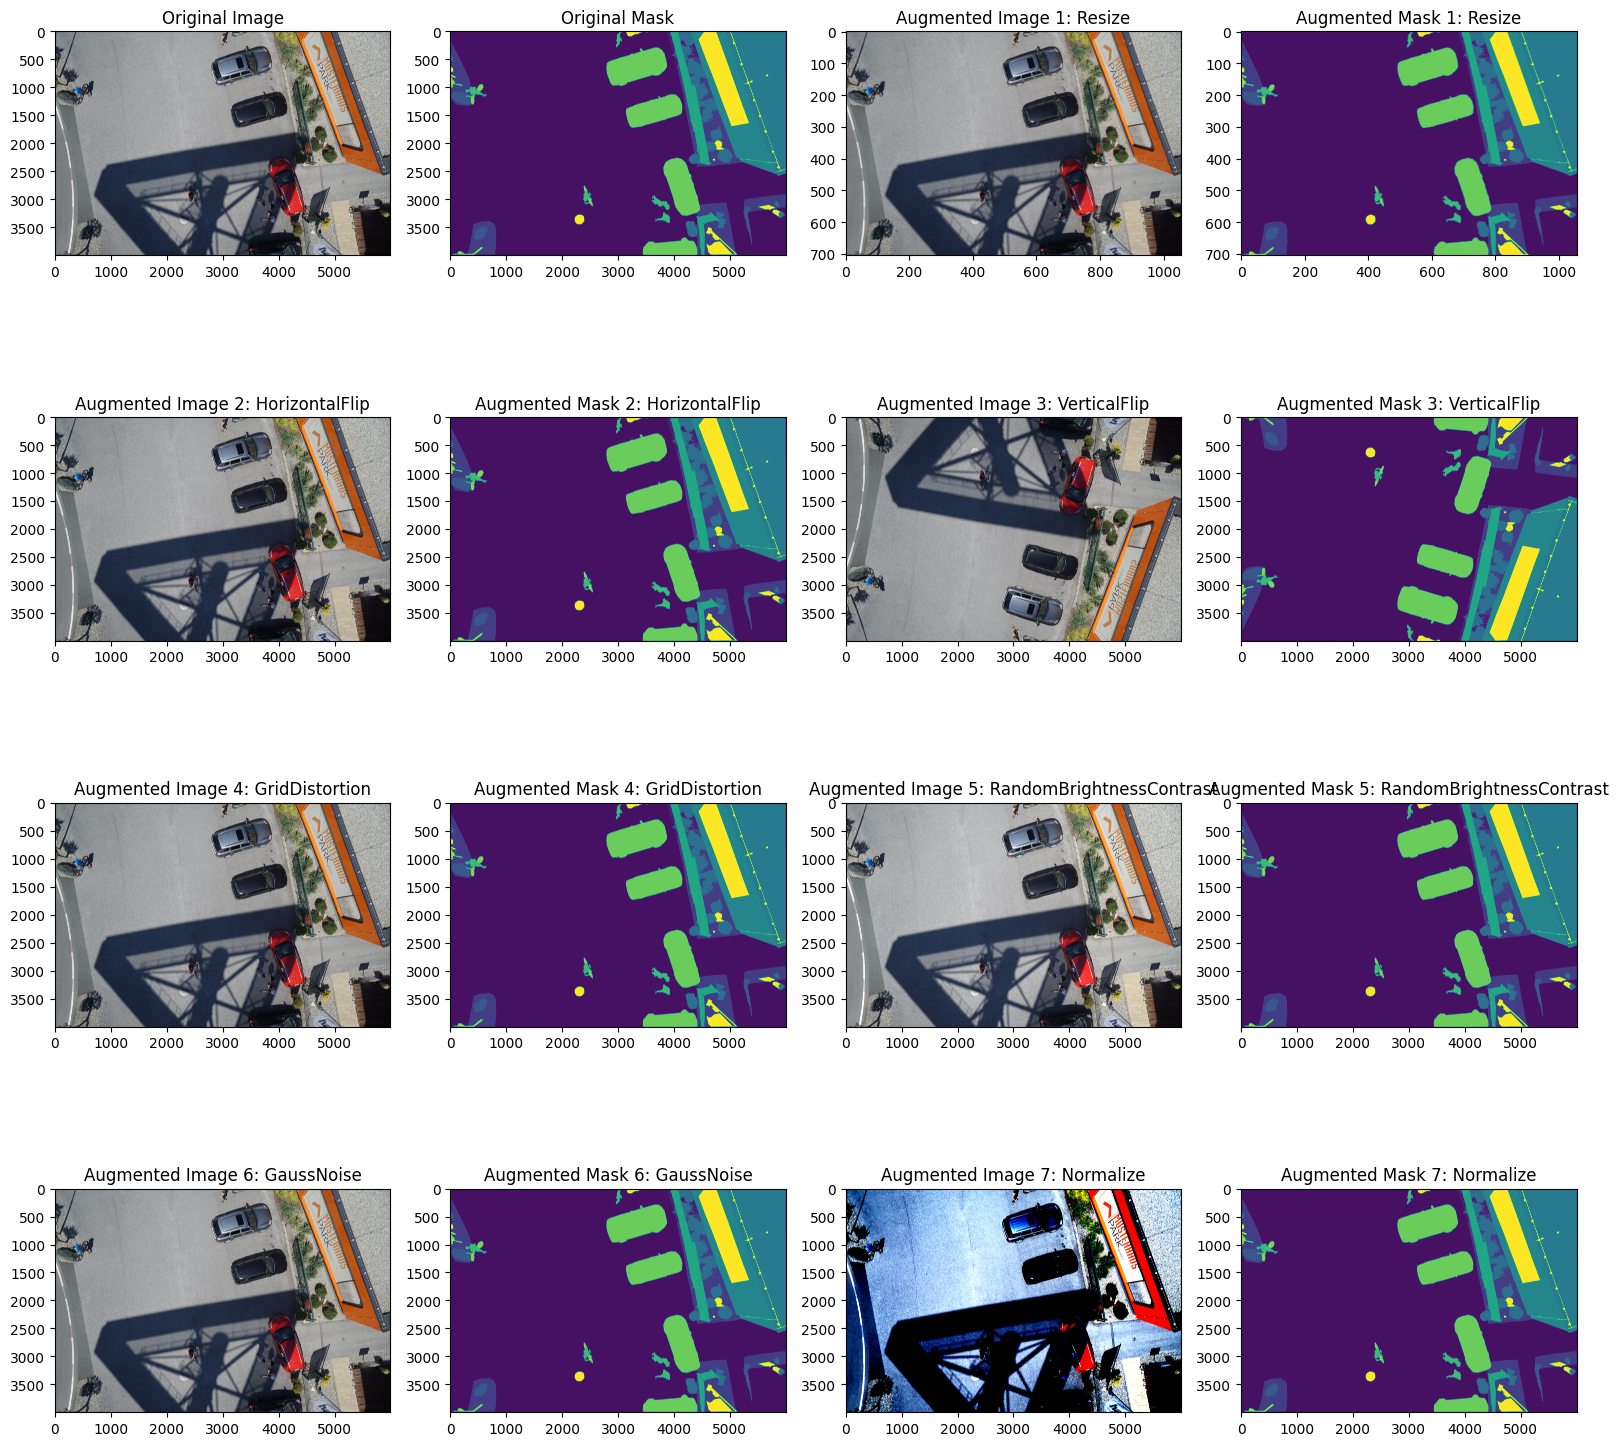

In [31]:
temp_index = 200
temp_image_path = IMAGE_PATH + df.iloc[temp_index]['id'] + '.jpg'
temp_mask_path  = MASK_PATH  + df.iloc[temp_index]['id'] + '.png'

display_augmented_samples( temp_image_path, temp_mask_path, t_display )

In [32]:
#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch = False )
val_set   = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch = False )

print(f'Length of train set: {len(train_set)}')
print(f'Length of valid set: {len(val_set)}')

Length of train set: 306
Length of valid set: 54


In [33]:
#dataloader
batch_size =  3 

train_loader = DataLoader( train_set, batch_size = batch_size, shuffle = True )
val_loader   = DataLoader( val_set,   batch_size = batch_size, shuffle = True ) 

print(f'Length of train loader: {len(train_loader)}')
print(f'Length of valid loader: {len(val_loader)}')

Length of train loader: 102
Length of valid loader: 18


## MODEL 1 - UNET 

In [34]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2)  

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, output_padding=0)  # Adjust output_padding if needed
        self.conv = conv_block(out_c + out_c, out_c)  # Adjust input channels for conv_block

    def forward(self, inputs, skip):
        
        x = self.up(inputs)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)  # Ensure concatenation is done along the correct dimension
        x = self.conv(x)
        return x


class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        
        """ Classifier """
        self.outputs = nn.Conv2d(64, 23, kernel_size=1)  # Adjusted output channels to match task

    def forward(self, inputs):
        
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        """ Bottleneck """
        b = self.b(p4)
        
        """ Decoder """
        
        d1 = self.d1(b, s4)      
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        """ Classifier """
        outputs = self.outputs(d4)
        
        return outputs


In [35]:
# Test the model 1 with sample input size
inputs = torch.randn(3, 3, 704, 1056)
model_unet = UNet()
outputs    = model_unet(inputs)
print("Output shape:", outputs.shape)

Output shape: torch.Size([3, 23, 704, 1056])


In [36]:
# Print the summary
summary(model_unet.to(device), (3, 704, 1056))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 704, 1056]           1,792
       BatchNorm2d-2        [-1, 64, 704, 1056]             128
              ReLU-3        [-1, 64, 704, 1056]               0
            Conv2d-4        [-1, 64, 704, 1056]          36,928
       BatchNorm2d-5        [-1, 64, 704, 1056]             128
              ReLU-6        [-1, 64, 704, 1056]               0
        conv_block-7        [-1, 64, 704, 1056]               0
         MaxPool2d-8         [-1, 64, 352, 528]               0
     encoder_block-9  [[-1, 64, 704, 1056], [-1, 64, 352, 528]]               0
           Conv2d-10        [-1, 128, 352, 528]          73,856
      BatchNorm2d-11        [-1, 128, 352, 528]             256
             ReLU-12        [-1, 128, 352, 528]               0
           Conv2d-13        [-1, 128, 352, 528]         147,584
      BatchNorm2d-14   

## MODEL 2 - UNET with MOBILENET

In [37]:
model_unet_mobilenet =   smp.Unet('mobilenet_v2',  # encoder architecture - using MobileNetV2 as the feature extractor.
                         encoder_weights  = 'imagenet',  # using pre-trained weights from ImageNet for the encoder
                         classes          = 23, 
                         activation       = None, 
                         encoder_depth    = 5,  # the number of blocks or layers in the encoder part of the UNet architecture
                         decoder_channels = [ 256, 128, 64, 32, 16 ] ) # number of output channels at each decoder block level

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 155MB/s]


## TRAINING

In [38]:
## This function calculates the pixel accuracy between the output/predicted mask and the actual mask
def pixel_accuracy( output, mask ):
    
    # no gradients are calculated
    with torch.no_grad():
        
        # Convert output probabilities to predicted class labels
        output   = torch.argmax( F.softmax( output, dim = 1 ), dim = 1 )
        
        # Compare element-wise between predicted labels and ground truth labels
        # element is 1 if the prediction matches the ground truth and 0 otherwise.
        correct  = torch.eq( output, mask ).int()
        
        # Calculate pixel accuracy
        # ratio of correctly predicted pixels to the total number of pixels
        accuracy = float( correct.sum() ) / float( correct.numel() )
        
    return accuracy

In [39]:
## This function omputes the mean Intersection over Union (mIoU) metric 
def mIoU( pred_mask, mask, smooth = 1e-10, n_classes = 23 ):
    
    # no gradients are calculated
    with torch.no_grad():
        
        # converts the logits (or scores) into probabilities for each class.
        pred_mask = F.softmax( pred_mask, dim = 1 )
#         print(f'predicted mas after softmax: {pred_mask.shape}')
#         print(pred_mask)
        
        # get the index with the maximum probability
        pred_mask = torch.argmax( pred_mask, dim = 1 )
#         print(f'predicted mask after argmax: {pred_mask.shape}')
#         print(pred_mask)
        
        # flattens the 2D tensors into 1D vectors
        pred_mask = pred_mask.contiguous().view(-1)
        mask      =      mask.contiguous().view(-1)
        
#         print(f'Flatten values pred:   {pred_mask}')
#         print(f'Flatten values actual: {mask}\n')

        iou_per_class = []
        
        #loop per pixel class
        for clas in range(0, n_classes):
            
            true_class = pred_mask == clas
#             print(f'\nTrue class: {true_class}')
            true_label = mask == clas
#             print(f'True label: {true_label}')

            if true_label.long().sum().item() == 0: #no exist label in this loop
#                 print('Inside if')
#                 print(true_label.long().sum().item())
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and( true_class, true_label ).sum().float().item()
                union     = torch.logical_or(  true_class, true_label ).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
                
        return np.nanmean(iou_per_class)

In [40]:
## Testing the mIoU function
pred_mask = torch.randn(1, 2, 64, 64)  # Example logits
mask      = torch.randint(0, 2, (1, 64, 64), dtype=torch.long)  # Example ground truth labels
print(pred_mask.shape)
print(mask.shape)

miou = mIoU(pred_mask, mask)
miou

torch.Size([1, 2, 64, 64])
torch.Size([1, 64, 64])


0.3374693700949986

In [41]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
## testing get_lr function
# get_lr( optimizer )

In [42]:
def fit( description, epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch = False ):
    
    torch.cuda.empty_cache()
    
    train_losses = []
    val_losses   = []
    
    train_iou    = []
    val_iou      = []
    
    train_acc    = []
    val_acc      = []
    
    lrs          = []
    
    min_loss     = np.inf
    decrease     = 1  
    not_improve  = 0

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since        = time.time()
        running_loss = 0
        iou_score    = 0
        accuracy     = 0
        
        # training loop
        model.train()
        for i, data in enumerate( tqdm(train_loader) ):
#             print('Inside training loop')
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles  = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            
            # forward
            output = model( image )
            loss   = criterion( output, mask )
            
            # evaluation metrics
            iou_score += mIoU( output, mask )
            accuracy  += pixel_accuracy( output, mask )
            
            # backward
            loss.backward()
            optimizer.step() # update weight          
            optimizer.zero_grad() # reset gradient
            
            # step the learning rate
            lrs.append( get_lr( optimizer ) )
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            val_loss     = 0
            val_accuracy = 0
            val_iou_score = 0
            
            # validation loop
            with torch.no_grad():
                for i, data in enumerate( tqdm(val_loader) ):
#                     print('Inside validation loop')
                    # validation phase
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles  =  mask_tiles.view(-1, h, w)
                    
                    image  = image_tiles.to(device)
                    mask   =  mask_tiles.to(device)
                    
                    output = model(image)
                    
                    # evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    val_accuracy +=  pixel_accuracy(output, mask)
                    
                    # loss
                    loss = criterion(output, mask)                                  
                    val_loss += loss.item()
            
            # calculate mean for each batch
            train_losses.append( running_loss / len(train_loader) )
            val_losses.append(     val_loss / len(val_loader) )


            if min_loss > ( val_loss / len( val_loader ) ):
                
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (val_loss / len(val_loader) ) ) )
                min_loss  = ( val_loss / len( val_loader ) )
#                 decrease += 1
#                 if decrease % 5 == 0:
                print('Saving Model........................')
                torch.save(model, description + '.pt' )

            if ( val_loss / len( val_loader ) ) > min_loss:
                not_improve += 1
                min_loss     = ( val_loss / len( val_loader ) )
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # iou
            val_iou.append(   val_iou_score / len( val_loader ) )
            train_iou.append( iou_score     / len( train_loader ) )
            
            train_acc.append(     accuracy / len( train_loader ) )
            val_acc.append(  val_accuracy / len( val_loader ) )
            
            print("Epoch:{}/{}..       ".format( e+1, epochs ),
                  
                  "Train Loss: {:.3f}..".format( running_loss  / len( train_loader ) ),
                  "Val Loss: {:.3f}..  ".format( val_loss     / len( val_loader ) ),
                  
                  "Train mIoU:{:.3f}.. ".format( iou_score     / len( train_loader ) ),
                  "Val mIoU: {:.3f}..  ".format( val_iou_score / len( val_loader ) ),
                  
                  "Train Acc:{:.3f}..  ".format( accuracy      / len( train_loader ) ),
                  "Val Acc:{:.3f}..    ".format( val_accuracy / len( val_loader ) ),
                  
                  "Time: {:.2f}m       ".format( ( time.time() - since ) / 60 ) )
        
    history = { 'train_loss' : train_losses, 
                'val_loss'   : val_losses,
               
                'train_miou' : train_iou, 
                'val_miou'   : val_iou,
               
                'train_acc'  : train_acc, 
                'val_acc'    : val_acc,
               
                'lrs'        : lrs}
    
    print('Total time: {:.2f} m' .format( ( time.time() - fit_time ) / 60 ) )
    
    return history

In [43]:
def optim_and_sched_fun( model, max_lr, weight_decay, epoch, len_train_loader ):
    
    optimizer = torch.optim.AdamW( model.parameters(), 
                                   lr = max_lr, 
                                   weight_decay = weight_decay )
    
    sched    = torch.optim.lr_scheduler.OneCycleLR( optimizer, 
                                                    max_lr, 
                                                    epochs = epoch,
                                                    steps_per_epoch = len_train_loader )
    return optimizer, sched

In [44]:
max_lr       = 1e-3
epoch        = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer_unet, sched_unet = optim_and_sched_fun( model_unet, 
                                                  max_lr, 
                                                  weight_decay,
                                                  epoch, 
                                                  len(train_loader) )

optimizer_unet_mobilenet, sched_unet_mobilenet = optim_and_sched_fun( model_unet_mobilenet, 
                                                                      max_lr, 
                                                                      weight_decay,
                                                                      epoch, 
                                                                      len(train_loader) )


### Fitting Model 1 -  Unet

In [45]:
history_unet = fit( 'unet', epoch, model_unet, train_loader, 
                    val_loader, criterion,  optimizer_unet, sched_unet )

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.396 
Saving Model........................
Epoch:1/100..        Train Loss: 2.725.. Val Loss: 2.396..   Train mIoU:0.067..  Val mIoU: 0.100..   Train Acc:0.375..   Val Acc:0.498..     Time: 4.71m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.396 >> 2.007 
Saving Model........................
Epoch:2/100..        Train Loss: 2.359.. Val Loss: 2.007..   Train mIoU:0.097..  Val mIoU: 0.116..   Train Acc:0.501..   Val Acc:0.593..     Time: 4.43m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/100..        Train Loss: 2.213.. Val Loss: 2.029..   Train mIoU:0.096..  Val mIoU: 0.113..   Train Acc:0.523..   Val Acc:0.583..     Time: 4.33m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.029 >> 1.779 
Saving Model........................
Epoch:4/100..        Train Loss: 2.032.. Val Loss: 1.779..   Train mIoU:0.105..  Val mIoU: 0.110..   Train Acc:0.553..   Val Acc:0.601..     Time: 4.38m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.779 >> 1.704 
Saving Model........................
Epoch:5/100..        Train Loss: 1.926.. Val Loss: 1.704..   Train mIoU:0.107..  Val mIoU: 0.120..   Train Acc:0.562..   Val Acc:0.617..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.704 >> 1.523 
Saving Model........................
Epoch:6/100..        Train Loss: 1.755.. Val Loss: 1.523..   Train mIoU:0.115..  Val mIoU: 0.143..   Train Acc:0.576..   Val Acc:0.653..     Time: 4.36m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.523 >> 1.406 
Saving Model........................
Epoch:7/100..        Train Loss: 1.688.. Val Loss: 1.406..   Train mIoU:0.116..  Val mIoU: 0.137..   Train Acc:0.570..   Val Acc:0.645..     Time: 4.36m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/100..        Train Loss: 1.576.. Val Loss: 1.447..   Train mIoU:0.118..  Val mIoU: 0.131..   Train Acc:0.583..   Val Acc:0.641..     Time: 4.34m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.447 >> 1.303 
Saving Model........................
Epoch:9/100..        Train Loss: 1.541.. Val Loss: 1.303..   Train mIoU:0.117..  Val mIoU: 0.136..   Train Acc:0.577..   Val Acc:0.660..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/100..        Train Loss: 1.484.. Val Loss: 1.335..   Train mIoU:0.123..  Val mIoU: 0.136..   Train Acc:0.590..   Val Acc:0.633..     Time: 4.37m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.335 >> 1.284 
Saving Model........................
Epoch:11/100..        Train Loss: 1.444.. Val Loss: 1.284..   Train mIoU:0.126..  Val mIoU: 0.139..   Train Acc:0.593..   Val Acc:0.633..     Time: 4.36m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.284 >> 1.225 
Saving Model........................
Epoch:12/100..        Train Loss: 1.381.. Val Loss: 1.225..   Train mIoU:0.130..  Val mIoU: 0.139..   Train Acc:0.609..   Val Acc:0.643..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.225 >> 1.222 
Saving Model........................
Epoch:13/100..        Train Loss: 1.387.. Val Loss: 1.222..   Train mIoU:0.129..  Val mIoU: 0.152..   Train Acc:0.608..   Val Acc:0.658..     Time: 4.37m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/100..        Train Loss: 1.407.. Val Loss: 1.241..   Train mIoU:0.132..  Val mIoU: 0.133..   Train Acc:0.605..   Val Acc:0.634..     Time: 4.38m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/100..        Train Loss: 1.359.. Val Loss: 1.267..   Train mIoU:0.132..  Val mIoU: 0.132..   Train Acc:0.608..   Val Acc:0.648..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.267 >> 1.194 
Saving Model........................
Epoch:16/100..        Train Loss: 1.355.. Val Loss: 1.194..   Train mIoU:0.134..  Val mIoU: 0.157..   Train Acc:0.600..   Val Acc:0.670..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:17/100..        Train Loss: 1.327.. Val Loss: 1.221..   Train mIoU:0.136..  Val mIoU: 0.142..   Train Acc:0.612..   Val Acc:0.628..     Time: 4.35m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 78.81 m


### Fitting Model 2 -  MobileNet-Unet

In [46]:
history_unet_mobile_net = fit( 'mobile_net', epoch, model_unet_mobilenet, train_loader, 
                               val_loader, criterion,  optimizer_unet_mobilenet, 
                               sched_unet_mobilenet )

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.103 
Saving Model........................
Epoch:1/100..        Train Loss: 2.736.. Val Loss: 2.103..   Train mIoU:0.044..  Val mIoU: 0.088..   Train Acc:0.260..   Val Acc:0.489..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.103 >> 1.654 
Saving Model........................
Epoch:2/100..        Train Loss: 2.149.. Val Loss: 1.654..   Train mIoU:0.098..  Val mIoU: 0.144..   Train Acc:0.499..   Val Acc:0.673..     Time: 3.02m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.654 >> 1.332 
Saving Model........................
Epoch:3/100..        Train Loss: 1.805.. Val Loss: 1.332..   Train mIoU:0.123..  Val mIoU: 0.165..   Train Acc:0.609..   Val Acc:0.726..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.332 >> 1.173 
Saving Model........................
Epoch:4/100..        Train Loss: 1.571.. Val Loss: 1.173..   Train mIoU:0.135..  Val mIoU: 0.164..   Train Acc:0.651..   Val Acc:0.734..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.173 >> 1.035 
Saving Model........................
Epoch:5/100..        Train Loss: 1.400.. Val Loss: 1.035..   Train mIoU:0.145..  Val mIoU: 0.175..   Train Acc:0.672..   Val Acc:0.754..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.035 >> 0.968 
Saving Model........................
Epoch:6/100..        Train Loss: 1.320.. Val Loss: 0.968..   Train mIoU:0.150..  Val mIoU: 0.179..   Train Acc:0.670..   Val Acc:0.744..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.968 >> 0.916 
Saving Model........................
Epoch:7/100..        Train Loss: 1.195.. Val Loss: 0.916..   Train mIoU:0.161..  Val mIoU: 0.196..   Train Acc:0.686..   Val Acc:0.765..     Time: 3.02m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.916 >> 0.897 
Saving Model........................
Epoch:8/100..        Train Loss: 1.128.. Val Loss: 0.897..   Train mIoU:0.165..  Val mIoU: 0.195..   Train Acc:0.687..   Val Acc:0.757..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.897 >> 0.820 
Saving Model........................
Epoch:9/100..        Train Loss: 1.072.. Val Loss: 0.820..   Train mIoU:0.177..  Val mIoU: 0.225..   Train Acc:0.703..   Val Acc:0.772..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.820 >> 0.757 
Saving Model........................
Epoch:10/100..        Train Loss: 0.956.. Val Loss: 0.757..   Train mIoU:0.212..  Val mIoU: 0.235..   Train Acc:0.735..   Val Acc:0.779..     Time: 3.02m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:11/100..        Train Loss: 0.941.. Val Loss: 0.818..   Train mIoU:0.240..  Val mIoU: 0.223..   Train Acc:0.737..   Val Acc:0.762..     Time: 3.04m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.818 >> 0.797 
Saving Model........................
Epoch:12/100..        Train Loss: 0.890.. Val Loss: 0.797..   Train mIoU:0.255..  Val mIoU: 0.250..   Train Acc:0.752..   Val Acc:0.773..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.797 >> 0.788 
Saving Model........................
Epoch:13/100..        Train Loss: 0.876.. Val Loss: 0.788..   Train mIoU:0.262..  Val mIoU: 0.263..   Train Acc:0.753..   Val Acc:0.779..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.788 >> 0.698 
Saving Model........................
Epoch:14/100..        Train Loss: 0.854.. Val Loss: 0.698..   Train mIoU:0.270..  Val mIoU: 0.291..   Train Acc:0.760..   Val Acc:0.802..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:15/100..        Train Loss: 0.920.. Val Loss: 0.726..   Train mIoU:0.260..  Val mIoU: 0.281..   Train Acc:0.736..   Val Acc:0.790..     Time: 2.98m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:16/100..        Train Loss: 0.823.. Val Loss: 0.810..   Train mIoU:0.285..  Val mIoU: 0.294..   Train Acc:0.768..   Val Acc:0.757..     Time: 3.02m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:17/100..        Train Loss: 0.837.. Val Loss: 0.950..   Train mIoU:0.290..  Val mIoU: 0.223..   Train Acc:0.762..   Val Acc:0.700..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.950 >> 0.696 
Saving Model........................
Epoch:18/100..        Train Loss: 0.945.. Val Loss: 0.696..   Train mIoU:0.260..  Val mIoU: 0.300..   Train Acc:0.723..   Val Acc:0.793..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.696 >> 0.677 
Saving Model........................
Epoch:19/100..        Train Loss: 0.817.. Val Loss: 0.677..   Train mIoU:0.292..  Val mIoU: 0.289..   Train Acc:0.765..   Val Acc:0.804..     Time: 3.01m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.677 >> 0.633 
Saving Model........................
Epoch:20/100..        Train Loss: 0.761.. Val Loss: 0.633..   Train mIoU:0.313..  Val mIoU: 0.317..   Train Acc:0.783..   Val Acc:0.822..     Time: 2.99m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:21/100..        Train Loss: 0.729.. Val Loss: 0.789..   Train mIoU:0.312..  Val mIoU: 0.281..   Train Acc:0.788..   Val Acc:0.771..     Time: 3.00m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.789 >> 0.685 
Saving Model........................
Epoch:22/100..        Train Loss: 0.787.. Val Loss: 0.685..   Train mIoU:0.303..  Val mIoU: 0.305..   Train Acc:0.772..   Val Acc:0.790..     Time: 3.03m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.685 >> 0.631 
Saving Model........................
Epoch:23/100..        Train Loss: 0.758.. Val Loss: 0.631..   Train mIoU:0.302..  Val mIoU: 0.313..   Train Acc:0.774..   Val Acc:0.809..     Time: 3.03m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:24/100..        Train Loss: 0.717.. Val Loss: 0.644..   Train mIoU:0.328..  Val mIoU: 0.344..   Train Acc:0.792..   Val Acc:0.812..     Time: 3.05m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.644 >> 0.597 
Saving Model........................
Epoch:25/100..        Train Loss: 0.722.. Val Loss: 0.597..   Train mIoU:0.333..  Val mIoU: 0.332..   Train Acc:0.791..   Val Acc:0.824..     Time: 3.04m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.597 >> 0.545 
Saving Model........................
Epoch:26/100..        Train Loss: 0.697.. Val Loss: 0.545..   Train mIoU:0.337..  Val mIoU: 0.391..   Train Acc:0.798..   Val Acc:0.834..     Time: 2.99m       


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 81.29 m


In [67]:
def plot_loss(desc, history, stop):
    plt.plot( history['val_loss'],   label = 'val',   marker = 'o' )
    plt.plot( history['train_loss'], label = 'train', marker = 'o' )
    
    # Plotting a vertical line on the stopping point
    plt.axvline(x=stop, color='r', linestyle='--', linewidth=1, label='Stop Training')
    
    plt.title(desc + ' Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_score(desc, history):
    plt.plot( history['train_miou'], label = 'train_mIoU', marker = '*' )
    plt.plot( history['val_miou'],   label = 'val_mIoU',   marker = '*' )
    plt.title(desc + ' mIoU per epoch')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_acc(desc, history):
    plt.plot( history['train_acc'], label = 'train_accuracy', marker = '*' )
    plt.plot( history['val_acc'],   label = 'val_accuracy',   marker = '*' )
    plt.title(desc + ' Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

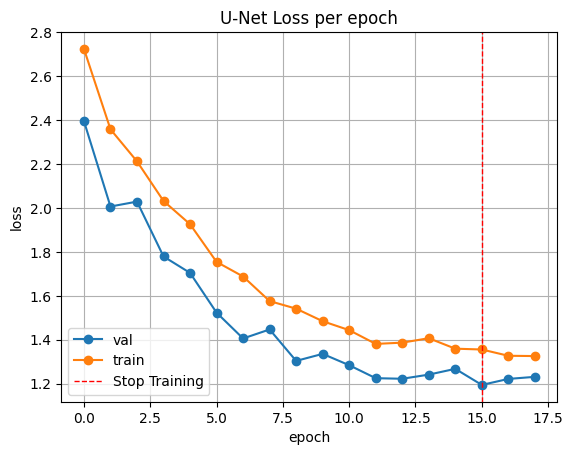

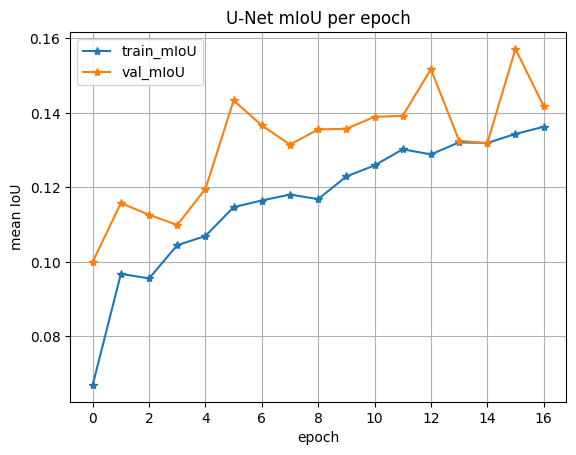

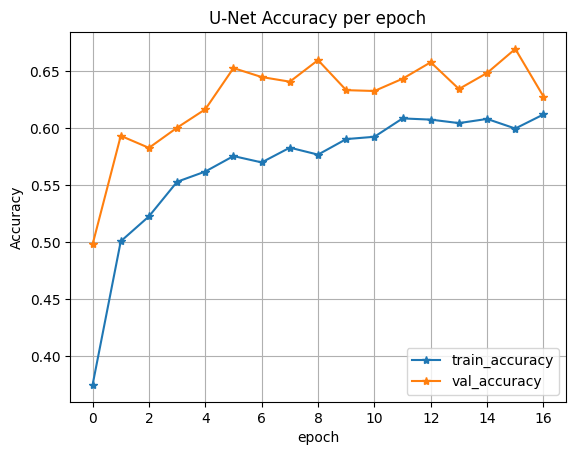

In [68]:
### Plotting UNet History
desc = 'U-Net'
plot_loss(  desc, history_unet, 15 )
plot_score( desc, history_unet )
plot_acc(   desc, history_unet )

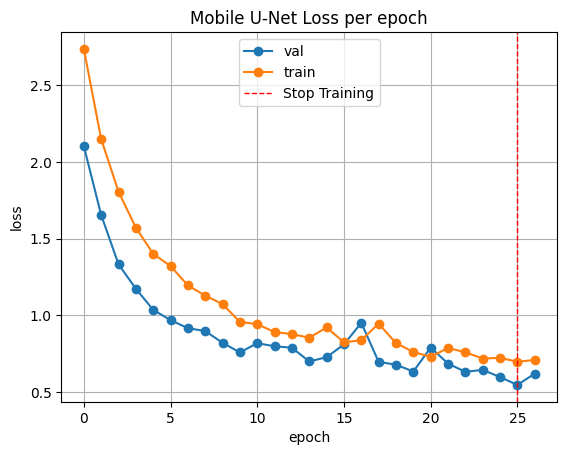

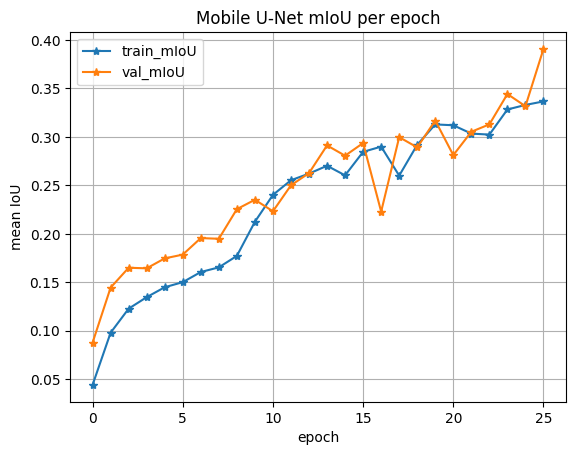

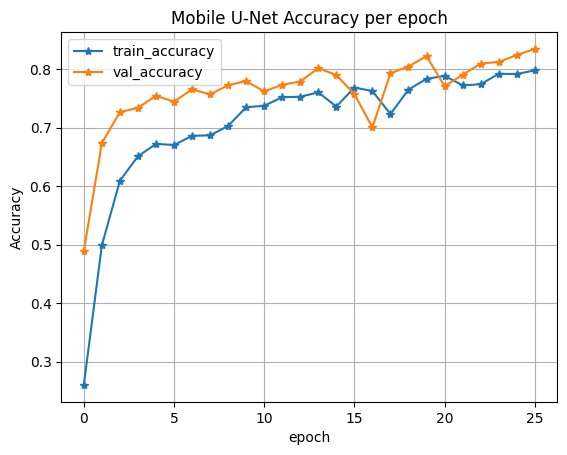

In [65]:
### Plotting UNet-MobileNet History
desc = 'Mobile U-Net'
plot_loss(  desc, history_unet_mobile_net, 25 )
plot_score( desc, history_unet_mobile_net )
plot_acc(   desc, history_unet_mobile_net )

In [66]:
## saving the models
torch.save( model_unet,           'Unet-Model.pt' )
torch.save( model_unet_mobilenet, 'Unet-Mobilenet-Model.pt' )

## EVALUATION

In [51]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path  = img_path
        self.mask_path = mask_path
        self.X         = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img  = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug  = self.transform(image=img, mask=mask)
            img  = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test   = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [52]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score  = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [53]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    model.eval()
    
    t     = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    
    model.to(device)
    
    image = image.to(device)
    mask  = mask.to(device)
    
    with torch.no_grad():
        
        image  = image.unsqueeze(0)
        mask   = mask.unsqueeze(0)
        
        output = model(image)
        acc    = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, acc

In [54]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm( range( len(test_set) ) ):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [55]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [60]:
# Load the saved models
model_unet = torch.load('/kaggle/working/unet.pt')
model_unet_mobilenet = torch.load('/kaggle/working/mobile_net.pt')

# Set the models to evaluation mode
model_unet.eval()
model_unet_mobilenet.eval()
print()

mob_miou_unet = miou_score( model_unet, test_set )
mob_acc_unet  = pixel_acc(  model_unet, test_set )

mob_miou_unet_mobilenet = miou_score( model_unet_mobilenet, test_set )
mob_acc_unet_mobilenet  = pixel_acc(  model_unet_mobilenet, test_set )
 
print('\nTest Set mIoU UNet:', round(np.mean(mob_miou_unet),3))
print('Test Set Pixel Accuracy UNet:', round(np.mean(mob_acc_unet),3),'\n')

print('Test Set mIoU UNet MobileNet:', round(np.mean(mob_miou_unet_mobilenet),3))
print('Test Set Pixel Accuracy UNet MobileNet:', round(np.mean(mob_acc_unet_mobilenet),3))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


Test Set mIoU UNet: 0.181
Test Set Pixel Accuracy UNet: 0.641 

Test Set mIoU UNet MobileNet: 0.387
Test Set Pixel Accuracy UNet MobileNet: 0.822


In [61]:
def plot_image_gt_and_predicted_mask( image, mask, pred_mask1, score1, desc1, pred_mask2, score2, desc2 ):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,20))
    
    ax1.imshow(image)
    ax1.set_title('Picture');
    ax1.set_axis_off()

    ax2.imshow(mask)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(pred_mask1)
    ax3.set_title(f'{desc1 } mIoU: {round(score1, 3)}')
    ax3.set_axis_off()
    
    ax4.imshow(pred_mask2)
    ax4.set_title(f'{desc2 } mIoU: {round(score2, 3)}')
    ax4.set_axis_off()

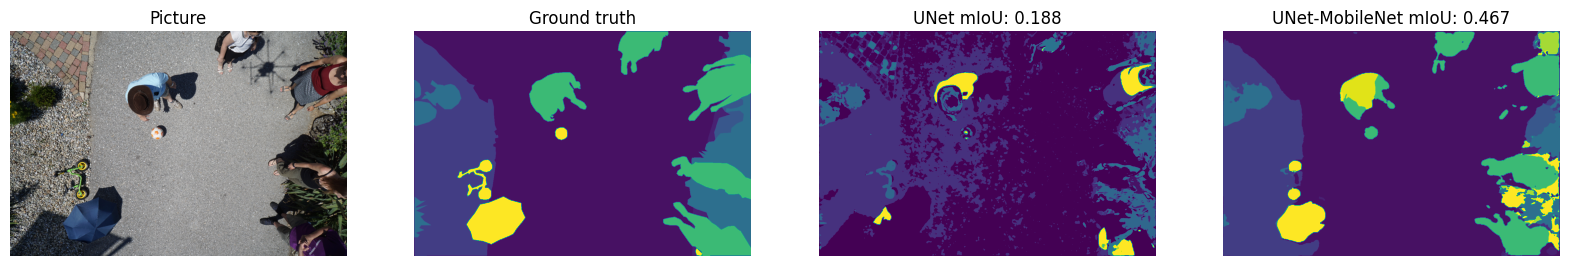

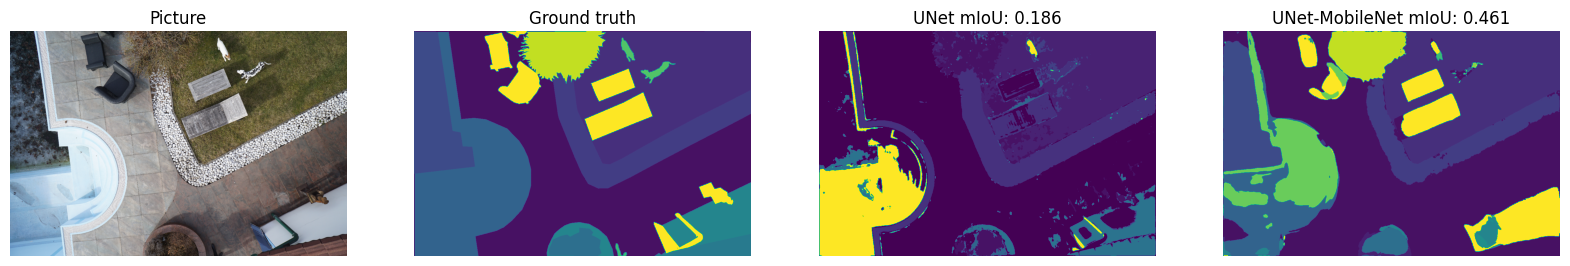

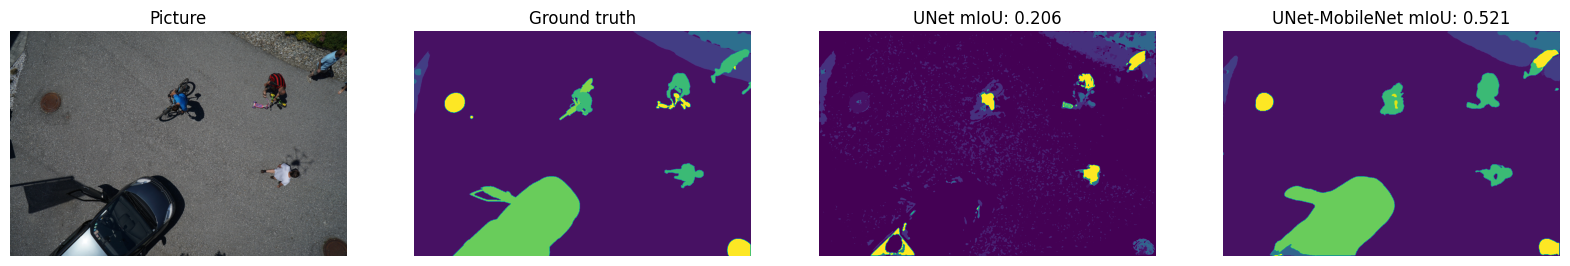

In [62]:
## UNet - Displaying original images along with actual and predicted masks

for i in [ 3, 4, 6 ]:
    image, mask = test_set[i]
    
    pred_mask1, score1 = predict_image_mask_miou(model_unet, image, mask)
    pred_mask2, score2 = predict_image_mask_miou(model_unet_mobilenet, image, mask)
    
    plot_image_gt_and_predicted_mask( image, mask, pred_mask1, score1, 'UNet', pred_mask2, score2, 'UNet-MobileNet' )
